In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv(r"..\data\raw\gold_price_featured_dataset.csv", index_col='Date', parse_dates=True)
data

,Close,MA_15,MA_60,Lag_1,Lag_2,Lag_7,Volatility_30,Pct_Change
Date,,,,,,,,
2015-03-30,1198.500000,1179.606665,1226.410000,1199.800049,1213.699951,1171.599976,21.958201,-0.001084
2015-03-31,1190.099976,1181.053328,1226.336666,1198.500000,1199.800049,1185.400024,20.663123,-0.007009
2015-04-01,1208.199951,1184.133325,1226.358331,1190.099976,1198.500000,1188.000000,20.609161,0.015209
2015-04-02,1205.699951,1187.146655,1226.119997,1208.199951,1190.099976,1193.000000,20.123269,-0.002069
2015-04-06,1224.199951,1191.479989,1226.203330,1205.699951,1208.199951,1199.199951,20.610419,0.015344
...,...,...,...,...,...,...,...,...
2025-12-23,4503.799805,4313.093327,4151.311666,4447.600098,4361.399902,4355.000000,109.653856,0.012636
2025-12-24,4503.399902,4331.046647,4161.943331,4503.799805,4447.600098,4349.200195,118.524467,-0.000089
2025-12-26,4556.299805,4354.013314,4173.016663,4503.399902,4503.799805,4321.399902,130.925508,0.011747


In [3]:
target_col_idx = data.columns.get_loc('Close')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print("Data after scaling: ", scaled_data.shape)

Data after scaling:  (2705, 8)


In [5]:
def create_sequences(dataset, target_col_index, time_steps=60):
    X, y = [], []

    for i in range(len(dataset) - time_steps):
        X.append(dataset[i : i + time_steps])
        y.append(dataset[i + time_steps, target_col_index])
    
    return np.array(X), np.array(y)

In [6]:
time_steps = 60

X, y = create_sequences(scaled_data, target_col_idx, time_steps)

print("Size of X: ", X.shape)
print("Size of y: ", y.shape)

Size of X:  (2645, 60, 8)
Size of y:  (2645,)


In [7]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (2116, 60, 8)
Shape of X_test:  (529, 60, 8)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [10]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Input(shape=(n_timesteps, n_features)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0,2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Training complete.")

Training model...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.1808e-04 - val_loss: 0.0048
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.0591e-04 - val_loss: 0.0040
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1727e-04 - val_loss: 0.0034
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4584e-04 - val_loss: 0.0050
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9190e-04 - val_loss: 0.0044
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8219e-04 - val_loss: 0.0045
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7819e-04 - val_loss: 0.0026
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5591e-04 - val_loss: 0.0025
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4714e-04 - val_loss: 0.0032
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2199e-04 - val_loss: 0.0026
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3048e-04 - val_loss: 0.0037
E

In [12]:
y_pred_scaled = model.predict(X_test)

num_features = scaler.n_features_in_
target_col_idx = 0

dummy_array = np.zeros((len(y_pred_scaled), num_features))

dummy_array[:, target_col_idx] = y_pred_scaled.flatten()

y_pred_real = scaler.inverse_transform(dummy_array)[:, target_col_idx]

dummy_array_test = np.zeros((len(y_test), num_features))
dummy_array_test[:, target_col_idx] = y_test.flatten()
y_test_real = scaler.inverse_transform(dummy_array_test)[:, target_col_idx]

print(f"Price prediction sample: {y_pred_real[:5]}")
print(f"Actual price sample: {y_test_real[:5]}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Price prediction sample: [1990.66408505 1988.35284075 1989.76380989 1997.20844505 2023.13897327]
Actual price sample: [1999.40002441 2002.19995117 2011.80004883 2042.69995117 2052.10009766]


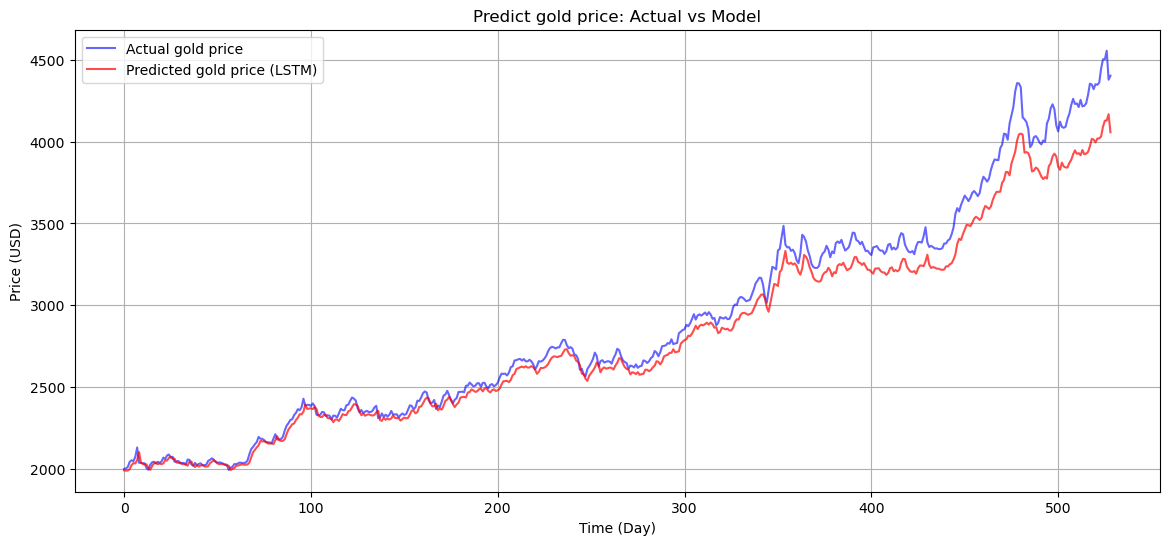

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(y_test_real, color='blue', label='Actual gold price', alpha=0.6)
plt.plot(y_pred_real, color='red', label='Predicted gold price (LSTM)', alpha=0.7)

plt.title('Predict gold price: Actual vs Model')
plt.xlabel('Time (Day)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

last_60_days = data[-60:].copy() 
last_60_days_scaled = scaler.transform(last_60_days)
X_future = np.array([last_60_days_scaled])
print("Predicted Shape input:", X_future.shape)

pred_future_scaled = model.predict(X_future)


dummy_future = np.zeros((1, num_features))
dummy_future[:, target_col_idx] = pred_future_scaled.flatten()

pred_future_real = scaler.inverse_transform(dummy_future)[:, target_col_idx]

print(f"--------------------------------------------------")
print(f"Model LSTM predicts the price gold next day: {pred_future_real[0]:.2f} USD")
print(f"--------------------------------------------------")

Predicted Shape input: (1, 60, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
--------------------------------------------------
Model LSTM predicts the price gold next day: 4083.87 USD
--------------------------------------------------


In [16]:
import joblib
model.save(r'..\models\gold_price_lstm_model.keras')
print("Done.")

joblib.dump(scaler, r'..\models\'gold_price_scaler.pkl')
print("Done.")

Done.
Done.
